<a href="https://colab.research.google.com/github/MerveNazlim/CatNN/blob/main/SvsBsstt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as p

p.seed(10)
#!/usr/bin/env python

import argparse
import sys
import os
from time import time
#from preprocess import mkdir_p, unique_filename
import pickle
import math


# h5py
import h5py
import tensorflow as tf
tf.random.set_seed(400)
from tensorflow import keras
# keras
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import models as Km
from tensorflow.keras import layers as Kl
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler,minmax_scale
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.losses import binary_crossentropy
from functools import partial
from tensorflow.keras import initializers
import numpy as np
seed = 400
np.random.seed(seed)
import mplhep as hep
    

In [2]:
tf.keras.backend.clear_session()

In [3]:
 def mkdir_p(path) :

    import errno

    """
    Make a directory, if it exists silence the exception

    Args:
        path : full directory path to be made
    """

    try :
        os.makedirs(path)
    except OSError as exc :
        if exc.errno == errno.EEXIST and os.path.isdir(path) :
            pass
        else :
            raise

In [4]:
path_tosave = '/mnt/c/Users/aaron/Desktop/'
file_name = 'sstt'
path_tosave = path_tosave + file_name
mkdir_p(path_tosave)

In [5]:
class Sample :

    """
    Sample

    This class will hold the feature data for a given sample.
    """

    def __init__(self, name = "", class_label = -1, input_data = None) :
        """
        Sample constructor

        Args :
            name : descriptive name of the sample (obtained from the input
                pre-processed file)
            input_data : numpy array of the data from the pre-processed file
                (expects an array of dtype = np.float64, not a structured array!)
            class_label : input class label as found in the input pre-processed
                file
        """

        if input_data.dtype != np.float64 :
            raise Exception("ERROR Sample input data must be type 'np.float64', input is '{}'".format(input_data.dtype))

        if class_label < 0 :
            raise ValueError("ERROR Sample (={})class label is not set (<0)".format(name, class_label))

        print("Creating sample {} (label = {})".format(name, class_label))

        self._name = name
        self._class_label = class_label
        self._input_data = input_data
        self._regression_inputs = None

    def name(self) :
        return self._name
    def class_label(self) :
        return self._class_label
    def data(self) :
        return self._input_data
    @property
    def regression_inputs(self) :
        return self._regression_inputs
    @regression_inputs.setter
    def regression_inputs(self, data) :
        self._regression_inputs = data
        


class DataScaler :

    """
    DataScaler

    This class will hold the scaling information needed for the training
    features (variables) contained in the input, pre-processed file.
    Its constructor takes as input the scaling data dataset object
    contained in the pre-processed file and it builds the associated
    feature-list and an associated dictionary to store the scaling
    parameters for each of the input features.
    """

    def __init__(self, scaling_dataset = None, ignore_features = []) :

        """
        ScalingData constructor

        Args:
            scaling_dataset : input HDF5 dataset object which contains the
                scaling data and feature-list
        """

        self._raw_feature_list = []
        self._feature_list = []
        self._scaling_dict = {}
        self._mean = []
        self._scale = []
        self._var = []
        self.load(scaling_dataset, ignore_features)

    def load(self, scaling_dataset = None, ignore_features = []) :

        self._raw_feature_list = list( scaling_dataset['name'] )
        self._feature_list = list( filter( lambda x : x not in ignore_features, self._raw_feature_list ) )

        #self._mean = scaling_dataset['mean']
        #self._scale = scaling_dataset['scale']
        #self._var = scaling_dataset['var']


        for x in scaling_dataset :
            name, mean, scale, var = x['name'], x['mean'], x['scale'], x['var']
            if name in ignore_features : continue
            self._scaling_dict[name] = { 'mean' : mean, 'scale' : scale, 'var' : var }
            self._mean.append(mean)
            self._scale.append(scale)
            self._var.append(var)

        self._mean = np.array(self._mean, dtype = np.float64)
        self._scale = np.array(self._scale, dtype = np.float64)
        self._var = np.array(self._var, dtype = np.float64)

    def raw_feature_list(self) :
        return self._raw_feature_list

    def feature_list(self) :
        return self._feature_list

    def scaling_dict(self) :
        return self._scaling_dict

    def get_params(self, feature = "") :
        if feature in self._scaling_dict :
            return self._scaling_dict[feature]
        raise KeyError("requested feature (={}) not found in set of scaling features".format(feature))

    def mean(self) :
        return self._mean
    def scale(self) :
        return self._scale
    def var(self) :
        return self._var

def floatify(input_array, feature_list) :
    ftype = [(name, float) for name in feature_list]
    return input_array.astype(ftype).view(float).reshape(input_array.shape + (-1,))

def load_input_file(args) :

    """
    Check that the provided input HDF5 file is of the expected form
    as defined by the pre-processing. Exits if this is not the case.
    Returns a list of the sample names found in the file.

    Args :
        args : user input to the executable
    """

    # check that the file can be found
    if not os.path.isfile(args) :
        print("ERROR provided input file (={}) is not found or is not a regular file".format(args))
        sys.exit()

    samples_group_name = "samples"
    scaling_group_name = "scaling"
    scaling_data_name = "scaling_data"

    found_samples = False
    found_scalings = False
    samples = []
    data_scaler = None
    #features_to_ignore = ["Mll01","Mll02","Mll03","Mll12","Mll13","Mll23"]
    features_to_ignore = ["DeltaR_min_lep_bjet77","DeltaR_max_lep_bjet77"]
    #features_to_ignore = [""]

    with h5py.File(args, 'r') as input_file :

        # look up the scalings first, in order to build the feature list used for the Sample creation
        if scaling_group_name in input_file :
            found_scalings = True
            scaling_group = input_file[scaling_group_name]
            scaling_dataset = scaling_group[scaling_data_name]
            data_scaler = DataScaler( scaling_dataset = scaling_dataset, ignore_features = features_to_ignore )
            print("DataScaler found {} features to train on (there were {} total features in the input)".format( len(data_scaler.feature_list()), len(data_scaler.raw_feature_list() )))
        else :
            print("scaling group (={}) not found in file".format(scaling_group_name))
            sys.exit()

        # now build the samples
        if samples_group_name in input_file :
            found_samples = True
            sample_group = input_file[samples_group_name]
            for p in sample_group :
                process_group = sample_group[p]
                class_label = process_group.attrs['training_label']
                s = Sample(name = p, class_label = int(class_label),
                    input_data = floatify( process_group['train_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list() ) )
                #print(floatify( process_group['train_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list() ))
                samples.append(s)

        else :
            print("samples group (={}) not found in file".format(samples_group_name))
            sys.exit()

    samples = sorted(samples, key = lambda x: x.class_label())

    return samples, data_scaler

def load_input_file_val(args) :

    if not os.path.isfile(args) :
        print("ERROR provided input file (={}) is not found or is not a regular file".format(args))
        sys.exit()

    samples_group_name = "samples"
    scaling_group_name = "scaling"
    scaling_data_name = "scaling_data"

    samples = []
    data_scaler = None

    with h5py.File(args, 'r', libver = 'latest') as input_file :

        # look up the scaling first
        if scaling_group_name in input_file :
            scaling_group = input_file[scaling_group_name]
            scaling_dataset = scaling_group[scaling_data_name]
            data_scaler = DataScaler( scaling_dataset = scaling_dataset, ignore_features = ["DeltaR_min_lep_bjet77","DeltaR_max_lep_bjet77"] )
            print("DataScaler found {} features to use as inputs (there were {} total features in the input)".format( len(data_scaler.feature_list()), len(data_scaler.raw_feature_list())))
        else :
            print("scaling group (={}) not found in file".format(scaling_group_name))
            sys.exit()

        # build the samples
        if samples_group_name in input_file :
            sample_group = input_file[samples_group_name]
            for p in sample_group :
                process_group = sample_group[p]
                class_label = process_group.attrs['training_label']
                s = Sample(name = p, class_label = int(class_label),
                    input_data = floatify( process_group['validation_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list()))
                samples.append(s)
        else :
            print("samples group (={}) not found in file".format(samples_group_name))
            sys.exit()

    return samples, data_scaler

def build_combined_input(training_samples, data_scaler = None, scale = True) :

    targets = []
    # used extended slicing to partition arbitrary number of samples
    sample0, sample1, *other = training_samples

    targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
    targets.extend( np.ones( sample1.data().shape[0] ) * sample1.class_label() )

    inputs = np.concatenate( (sample0.data(), sample1.data()), axis = 0)
    for sample in other :
        inputs = np.concatenate( (inputs, sample.data()) , axis = 0 )
        targets.extend( np.ones( sample.data().shape[0] ) * sample.class_label() )

    # perform scaling
    input_notscale = inputs
    if scale :
        inputs = (inputs - data_scaler.mean()) / data_scaler.scale()
        #print(inputs)

    targets = np.array(targets, dtype = int )


    return inputs, targets, input_notscale

In [6]:
def make_nn_output_plots_oddeven( path_tosave, model = None, inputs = None, samples = None, targets = None, events=None) :

    #inputs_tek = inputs[events % 2==1]
    #inputs_cift = inputs[events % 2==0]
    
    ## Workaround if no eventnumbers are used:
    # Shuffle + split into two equal size arrays
    np.random.shuffle(inputs)
    inputs_tek = inputs_test[0:int(inputs.shape[0]/2),:]
    inputs_cift = inputs_test[int(inputs.shape[0]/2):int(inputs_test.shape[0]),:]
    
    nn_scores = np.ones([targets.size,2])
    nn_scores_tek = model[0].predict(inputs_tek,verbose = True)
    nn_scores_cift = model[1].predict(inputs_cift,verbose = True)
    nn_scores[0:int(inputs.shape[0]/2),0] = nn_scores_tek.flatten()
    nn_scores[0:int(inputs.shape[0]/2),1] = abs(nn_scores_tek - 1).flatten()
    nn_scores[int(inputs.shape[0]/2):int(inputs.shape[0]),0] = nn_scores_cift.flatten()
    nn_scores[int(inputs.shape[0]/2):int(inputs.shape[0]),1] = abs(nn_scores_cift - 1).flatten()
    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}

    # index the sample names by their class label
    names = {}
    for sample in samples :
        names[sample.class_label()] = sample.name()

    # break up the predicted scores by the class label
    for ilabel, label in enumerate(class_labels) :
        # left-most appearance of the label
        left = targets_list.index(label)
        # right-most appearance of the label
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = nn_scores[left:right+1]

    # start plotting
    for label in class_labels :
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
        plt.xlabel( "NN output for label {}".format(names[label]), horizontalalignment='right', x=1)
        #ax.set_xlim([1e-2,1.0])
        plt.xlim([0,1])
        #plt.yscale('log')
        histargs = {"bins":20, "range":(0,1.), "density":True, "histtype":'step'}
        #binning = np.arange(0,1,0.02)
        #centers = (binning[1:-2] + binning[2:-1])/2
        #ax.set_xlim((centers[0]-0.1, centers[-1]+0.1)) 
        for sample_label in nn_scores_dict :
            sample_scores_for_label = nn_scores_dict[sample_label][:]
            print(sample_scores_for_label)
            #sample_weights = sample_with_label(sample_label, samples).eventweights

            #yields, _ = np.histogram(sample_scores_for_label, bins = binning)
            plt.hist(sample_scores_for_label,label = names[sample_label], **histargs)
            #yields = yields/yields.sum()
            #ax.step(centers, yields[1:-1], label = names[sample_label], where = 'mid')
            
            #ax.hist(sample_scores_for_label, bins = binning, alpha = 0.3, label = names[sample_label], density = True)
        plt.legend(loc='best', frameon = False)
        savename = "nn_outputs_class_{}.pdf".format( names[label])

        savename = "{}/{}".format(path_tosave, savename) 
        plt.savefig(savename, bbox_inches = 'tight', dpi = 200)
       # savename = "nn_outputs_{}_class_{}.pdf".format(path_tosave, names[label])

     #   savename = "{}/{}".format(path_tosave, savename) 
     #   plt.savefig(savename, bbox_inches = 'tight', dpi = 200)

    return nn_scores

In [8]:
def make_nn_output_plots( model = None, inputs = None, samples = None, targets = None) :

    # set of scores for each label: shape = (n_samples, n_outputs)
    nn_scores = model.predict(inputs,verbose = True)

    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}

    # index the sample names by their class label
    names = {}
    for sample in samples :
        names[sample.class_label()] = sample.name()

    # break up the predicted scores by the class label
    for ilabel, label in enumerate(class_labels) :
        # left-most appearance of the label
        left = targets_list.index(label)
        # right-most appearance of the label
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = nn_scores[left:right+1]

    # start plotting
    for label in class_labels :
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
        plt.xlabel( "NN output for label {}".format(names[label]), horizontalalignment='right', x=1)
        #ax.set_xlim([1e-2,1.0])
        plt.xlim([0,1])
        #plt.yscale('log')
        histargs = {"bins":20, "range":(0,1.), "density":True, "histtype":'step'}
        #binning = np.arange(0,1,0.02)
        #centers = (binning[1:-2] + binning[2:-1])/2
        #ax.set_xlim((centers[0]-0.1, centers[-1]+0.1)) 
        for sample_label in nn_scores_dict :
            sample_scores_for_label = nn_scores_dict[sample_label][:]
            print(sample_scores_for_label)
            #sample_weights = sample_with_label(sample_label, samples).eventweights

            #yields, _ = np.histogram(sample_scores_for_label, bins = binning)
            plt.hist(sample_scores_for_label,label = names[sample_label], **histargs)
            #yields = yields/yields.sum()
            #ax.step(centers, yields[1:-1], label = names[sample_label], where = 'mid')
            
            #ax.hist(sample_scores_for_label, bins = binning, alpha = 0.3, label = names[sample_label], density = True)
        plt.legend(loc='best', frameon = False)
        savename = "nn_outputs_class_{}.pdf".format( names[label])

        savename = "{}/{}".format(path_tosave, savename) 
        plt.savefig(savename, bbox_inches = 'tight', dpi = 200)
       # savename = "nn_outputs_{}_class_{}.pdf".format(path_tosave, names[label])

     #   savename = "{}/{}".format(path_tosave, savename) 
     #   plt.savefig(savename, bbox_inches = 'tight', dpi = 200)

    return nn_scores

In [9]:
def ScaleWeights(y,w):
    sum_wpos = sum( w[i] for i in range(len(y)) if y[i] == 1.0  )
    sum_wneg = sum( w[i] for i in range(len(y)) if y[i] == 0.0  )

    for i in range(len(w)):
        if (y[i]==1.0):
            w[i] = w[i] * (0.5/sum_wpos)
        else:
            w[i] = w[i] * (0.5/sum_wneg)

    w_av = sum(w)/len(w)
    w[:] = [x/w_av for x in w]
     
    sum_wpos_check = sum( w[i] for i in range(len(y)) if y[i] == 1.0  )
    sum_wneg_check = sum( w[i] for i in range(len(y)) if y[i] == 0.0  )

    print ('\n======Weight Statistic========================================')
    print ('Weights::        W(1)=%g, W(0)=%g' % (sum_wpos, sum_wneg))
    print ('Scaled weights:: W(1)=%g, W(0)=%g' % (sum_wpos_check, sum_wneg_check))
    print ('==============================================================')

In [10]:
def ScaleWeightsSignal(w,y):
    sumi = sum( w[i] for i in range(len(y)) if y[i] == 1.0 )


    for i in range(len(w)):
      if (y[i]==1.0):
        w[i] = sumi/len(w)
      else: 
        w[i] = w[i]
    

In [11]:
training_samples, data_scaler = load_input_file('data/sstt_weights.h5')

DataScaler found 10 features to train on (there were 10 total features in the input)
Creating sample background (label = 0)
Creating sample signal (label = 1)


In [12]:
input_features, targets, inp_nonsc= build_combined_input(training_samples, data_scaler = data_scaler, scale = True)

In [13]:
#2lSS
weights=inp_nonsc[:,-1]
weights[targets==1]

array([0.00140038, 0.00446875, 0.00443074, ..., 0.00461776, 0.0050069 ,
       0.00346192])

In [14]:
evtnum = inp_nonsc[:,-1]
#Drop Weight Coloumn
inp_nonsc = inp_nonsc[:,0:-1]

In [15]:
targets = targets[np.where((weights<1) &(weights>0))]
inp_nonsc = inp_nonsc[np.where((weights<1) &(weights>0))]
evtnum =evtnum[np.where((weights<1) &(weights>0))]

In [16]:
weights = weights[np.where((weights<1) &(weights>0))]

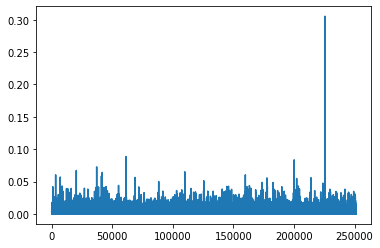

In [17]:
plt.plot((weights[targets==0]))

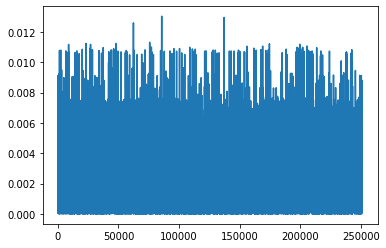

In [18]:
plt.plot(weights[targets==1])

In [19]:
ScaleWeights(targets,weights)


======Weight Statistic========================================
Weights::        W(1)=1140.91, W(0)=471.375
Scaled weights:: W(1)=251241, W(0)=251241


In [20]:
from collections import Counter
counter = Counter(targets)
print(counter)

Counter({0: 251241, 1: 251241})


In [21]:
#scale the input between 0-1
#print(inp_nonsc)
scaler = StandardScaler().fit(inp_nonsc)
print(inp_nonsc)
inp_nonsc = scaler.transform(inp_nonsc)
print(inp_nonsc)
#inp_nonsc.shape

[[4.00000000e+00 1.00000000e+00 5.00000000e+00 ... 3.12736250e+05
  7.47229062e+04 2.16903047e+05]
 [6.00000000e+00 5.00000000e+00 1.00000000e+00 ... 4.32814906e+05
  1.00001992e+05 2.22915469e+05]
 [7.00000000e+00 3.00000000e+00 2.00000000e+00 ... 5.38805375e+05
  1.02151969e+05 9.27254219e+04]
 ...
 [3.00000000e+00 1.00000000e+00 1.00000000e+00 ... 4.50074094e+05
  4.53176133e+04 1.78305969e+05]
 [6.00000000e+00 5.00000000e+00 5.00000000e+00 ... 7.84143625e+05
  4.57842383e+04 9.00132969e+04]
 [3.00000000e+00 1.00000000e+00 5.00000000e+00 ... 2.91216125e+05
  1.45114094e+05 1.12973891e+05]]
[[ 0.01876467 -1.24122022  1.10369847 ... -0.55443049 -0.29336801
  -0.23280678]
 [ 1.09017064  0.98226258 -1.065905   ... -0.15071604 -0.17935377
  -0.21309283]
 [ 1.62587363 -0.12947882 -0.52350413 ...  0.20563275 -0.1696569
  -0.63996913]
 ...
 [-0.51693832 -1.24122022 -1.065905   ... -0.09268921 -0.42599234
  -0.3593616 ]
 [ 1.09017064  0.98226258  1.10369847 ...  1.03048039 -0.42388776
  -0.6

In [22]:
import pickle
scalerfile = path_tosave+'/scaler_standard.bin'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [23]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [24]:
def exponential_decay_fn(epoch): 
  return 0.05 * 0.1**(epoch / 20)

In [25]:
def lr_step_decay(epoch) : #initial_lr, drop, epoch_to_drop) :

    initial_lr = 0.01
    drop = 0.9
    epoch_to_drop = 3

    if epoch >= 50 :
        epoch == 50
    elif epoch >= 25 :
        epoch -= 25
#        new_lr = initial_lr
        print('INFO Setting learning rate back to initial LR (={})'.format(initial_lr))

    new_lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epoch_to_drop))
    print('INFO LR Schedule: {}'.format(new_lr))
    return new_lr

In [26]:
auc_scores = []
auc_targets = []
acc_per_fold = []
loss_per_fold = []
results = []
model_history = []
fitfull_history = []
callbacks = []

In [27]:
    def fit_func2(n_classes, input_features_scale, targets, n_epochs = 400, batch_size = 2000, num_folds = 10) :
        # Define the K-fold Cross Validator
        #kfold = GroupKFold(n_splits=1)
        kfold = StratifiedKFold(n_splits=2)
        # Define per-fold score containers
        acc_per_fold = []
        loss_per_fold = []
        number = int((targets.size)/2)
        #group = [0,1]*number
        group = evtnum % 2 ==0
        targets_encoded=targets
        # K-fold Cross Validation model evaluation
        fold_no = 1
        for train, test in kfold.split(input_features_scale, targets_encoded,group):
            print("TRAIN:", train, "TEST:", test)
            layer_opts = dict( activation = 'sigmoid', kernel_initializer = initializers.glorot_normal(seed=seed))
            input_layer = Kl.Input(shape = (inp_nonsc.shape[1],) )
            x = Kl.Dense( 36, **layer_opts) (input_layer)
            x = Kl.Dropout(0.4)(x)
            x = Kl.Dense( 48, **layer_opts) (x)
            y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
            model = Km.Model(inputs= input_layer, outputs=y_pred )
            model_optimizer = Adam(lr=0.0001)
            model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
            model.summary() 
            lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')
              # Fit data to model
            train_X, test_X = input_features_scale[train], input_features_scale[test]
            train_y, test_y = targets_encoded[train], targets_encoded[test]
            w_train = weights[train]
            train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
            test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
            print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
            fit_history = model.fit(train_X, train_y, epochs = n_epochs, shuffle = True, batch_size = batch_size ,validation_data = (test_X,test_y), sample_weight=w_train,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = True, min_delta = 0.001),lr_schedule]) #
            scores = model.evaluate(test_X, test_y,batch_size=batch_size, verbose=0)
            nn_scores = model.predict(test_X,verbose = True)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
            acc_per_fold.append(scores[1] * 100)
            loss_per_fold.append(scores[0])
            results.append(scores)
            model_history.append(model)
            fitfull_history.append(fit_history)
            auc_scores.append(nn_scores)
            auc_targets.append(targets[test])

              # Increase fold number
            fold_no = fold_no + 1
        #fit_history = model1.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, shuffle = True, validation_data = (x_val, y_val),callbacks=callback)

        #self._fit_history = self._model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, shuffle = True, validation_data = (x_val, y_val), callbacks = callbacks)
        return model_history, fitfull_history, results

In [28]:
my_model_fin_func, fit_history_func,results = fit_func2( len(training_samples)-1, inp_nonsc, targets, n_epochs = 70, batch_size = 2000, num_folds = 2)

TRAIN: [125621 125622 125623 ... 502479 502480 502481] TEST: [     0      1      2 ... 376858 376859 376860]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 36)                360       
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_________________________________________________________________
----------------

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


251241/251241 [==============================] - 0s 1us/sample - loss: 0.3140 - accuracy: 0.8803 - val_loss: 0.2756 - val_accuracy: 0.8868
INFO LR Schedule: 0.009000000000000001
Epoch 3/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.3063 - accuracy: 0.8827 - val_loss: 0.2792 - val_accuracy: 0.8850
INFO LR Schedule: 0.009000000000000001
Epoch 4/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.3021 - accuracy: 0.8836 - val_loss: 0.2702 - val_accuracy: 0.8880
INFO LR Schedule: 0.009000000000000001
Epoch 5/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2985 - accuracy: 0.8847 - val_loss: 0.2714 - val_accuracy: 0.8877
INFO LR Schedule: 0.008100000000000001
Epoch 6/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2971 - accuracy: 0.8851 - val_loss: 0.2694 - val_accuracy: 0.8882
INFO LR Schedule: 0.008100000000000001
Epoch 7/70
251241/251241 [==============================] - 0s 1us

INFO LR Schedule: 0.00531441
Epoch 19/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2876 - accuracy: 0.8887 - val_loss: 0.2602 - val_accuracy: 0.8919
INFO LR Schedule: 0.00531441
Epoch 20/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2873 - accuracy: 0.8888 - val_loss: 0.2608 - val_accuracy: 0.8920
INFO LR Schedule: 0.004782969000000001
Epoch 21/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2878 - accuracy: 0.8889 - val_loss: 0.2609 - val_accuracy: 0.8912
INFO LR Schedule: 0.004782969000000001
Epoch 22/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2866 - accuracy: 0.8896 - val_loss: 0.2596 - val_accuracy: 0.8920
INFO LR Schedule: 0.004782969000000001
Epoch 23/70
251241/251241 [==============================] - 0s 1us/sample - loss: 0.2860 - accuracy: 0.8894 - val_loss: 0.2583 - val_accuracy: 0.8924
INFO LR Schedule: 0.004304672100000001
Epoch 24/70
251241/251241 [====

In [ ]:
for x in range(0,2):
    plt.plot(fit_history_func[x].history['loss'], label='Train. fold-'+str(x))
    plt.plot(fit_history_func[x].history['val_loss'], label='Val. fold-'+str(x))
    plt.title('DNN ($D_{in}$=7, $D_{hidden}$=2, 0.2Drop)')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

saveit = "{}/{}".format(path_tosave, "dnn_lossepo.png") 
plt.savefig(saveit)
plt.show()

In [ ]:
for x in range(0,2):
    plt.plot(fit_history_func[x].history['accuracy'], label='Train. fold-'+str(x))
    plt.plot(fit_history_func[x].history['val_accuracy'], label='Val. fold-'+str(x))
    plt.title('DNN ($D_{in}$=7, $D_{hidden}$=2, 0.2Drop)')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')

saveit = "{}/{}".format(path_tosave, "dnn_accepo.png") 
plt.savefig(saveit)
plt.show()

In [ ]:
output_dir = path_tosave
file_name = "2hdm"
job_suff = "_{}".format(file_name)
arch_name = "architecture_cift{}.json".format(job_suff)
weights_name = "weights_cift{}.h5".format(job_suff)

mkdir_p(output_dir)
arch_name = "{}/{}".format(output_dir, arch_name)
weights_name = "{}/{}".format(output_dir, weights_name)

print("Saving architecture to: {}".format(os.path.abspath(arch_name)))
print("Saving weights to     : {}".format(os.path.abspath(weights_name)))
with open(arch_name, 'w') as arch_file :
    arch_file.write(my_model_fin_func[0].to_json())
my_model_fin_func[0].save_weights(weights_name)

In [ ]:
output_dir = path_tosave
file_name = "2hdm"
job_suff = "_{}".format(file_name)
arch_name = "architecture_tek{}.json".format(job_suff)
weights_name = "weights_tek{}.h5".format(job_suff)

mkdir_p(output_dir)
arch_name = "{}/{}".format(output_dir, arch_name)
weights_name = "{}/{}".format(output_dir, weights_name)

print("Saving architecture to: {}".format(os.path.abspath(arch_name)))
print("Saving weights to     : {}".format(os.path.abspath(weights_name)))
with open(arch_name, 'w') as arch_file :
    arch_file.write(my_model_fin_func[1].to_json())
my_model_fin_func[1].save_weights(weights_name)

In [ ]:
#load the model
def load_model(arch_path, weights_path) :
    #arch_name = "/home/jovyan/test2/architecture_test2.json"
    #weights_name = "/home/jovyan/test2/weights_test2.h5"
    print(os.path.abspath(arch_path))
    print("Loading model architecture and weights (%, %)".format(os.path.abspath(arch_path), os.path.abspath(weights_path)))
    from tensorflow.keras.models import model_from_json
    json_file = open(os.path.abspath(arch_path), 'r')
    loaded_model = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model)
    loaded_model.load_weights(os.path.abspath(weights_path))
    return loaded_model

In [ ]:
arch_path = "{}/architecture_cift_2hdm.json".format(path_tosave)
weights_path = "{}/weights_cift_2hdm.h5".format(path_tosave)
my_model_loaded_cift = load_model(arch_path, weights_path)

In [ ]:
arch_path = "{}/architecture_tek_2hdm.json".format(path_tosave)
weights_path = "{}/weights_tek_2hdm.h5".format(path_tosave)
my_model_loaded_tek = load_model(arch_path, weights_path)

In [ ]:
nn_scores_2 = make_nn_output_plots_oddeven( path_tosave, [my_model_loaded_cift,my_model_loaded_tek], inputs = inp_nonsc, samples = training_samples,  targets = targets, events=evtnum)

In [ ]:
def plot_roc_curve(pred,truth,label):
    fpr, tpr, thr = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(path_tosave+"/roc{}.png".format(label))
    plt.show()

In [ ]:
nn_scores = nn_scores_2[:,0]

In [ ]:
plot_roc_curve(nn_scores,targets,"all")

In [ ]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz
area = trapz(targets, dx=5)
print("area =", area)

In [ ]:
plt.figure(0).clf()
plt.style.use('default')
plt.figure(figsize=[8,6])
color = ['blue', 'orange', 'red', 'green', 'coral',
             'grey', 'indigo', 'gold', 'lime', 'olive',
             'pink', 'navy', 'magenta', 'yellow', 'tomato',
             'turquoise', 'yellowgreen', 'maroon', 'lightblue']


fpr, tpr, thr = roc_curve(targets,nn_scores_2)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=color[0], lw=1,
             label='ROC curve w/ dCorr train (area = {:.2f})'.format(roc_auc),linestyle='dashed')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

fpr, tpr, thr = roc_curve(targets_val,nn_scores_val)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=color[1], lw=1,
             label='ROC curve w/ dCorr val (area = {:.2f})'.format(roc_auc),linestyle='solid')
plt.legend(loc="lower right")

In [ ]:
import mplhep as hep

In [ ]:
input_features2, targets2, inp_nonsc2= build_combined_input(training_samples, data_scaler = data_scaler, scale = True)

In [ ]:
plt.style.use('default')

bins = np.arange(0,800,10)
bins2 = np.arange(0.0,1.0,0.1)
f, ax = plt.subplots()
h4 = np.array([])
h5 = np.array([])
h6 = np.array([])
#for i, j in df44.iterrows(): 
#    h4 = np.append(h4, j[df4['ptnames2'][i]]/1000)

#for i, j in df55.iterrows(): 
#    h5 = np.append(h5, j[df5['ptnames2'][i]]/1000)
#print(h)
#for i, j in df66.iterrows(): 
#    h6 = np.append(h6, j[df6['ptnames2'][i]]/1000)
pt = inp_nonsc2[:,6]/1000
signalpt = pt[targets==1]
backpt = pt[targets==0]
signal_sc = nn_scores_2[targets==1]
back_sc = nn_scores_2[targets==0]
h44, bins = np.histogram(signalpt, bins)
h55, bins = np.histogram(backpt, bins)
#h66, bins = np.histogram(h6, bins)
h1,bins2 = np.histogram(signal_sc, bins2)
h2,bins2 = np.histogram(back_sc, bins2)

hep.histplot([h44 ,h55], bins ,label=['signal','back'], linewidth=2.0, density=True)

#    print() 
#row = next(df2.iterrows())[1]
#print(row)
ax.legend()
#ax.set_xlabel("$p_T$ of the c-jet", fontsize=12)

In [ ]:
plt.style.use('default')
f1, ax1 = plt.subplots()
h1,bins2 = np.histogram(signal_sc, bins2)
h2,bins2 = np.histogram(back_sc, bins2)
hep.histplot([h1 ,h2], bins2 ,label=['signal','back'], linewidth=2.0, density=True)
ax1.legend()